<a href="https://colab.research.google.com/github/felipe-piano/TCC---SINAIS-DE-VIBRACAO-DE-ROLAMENTOS-COM-VELOCIDADE-VARIAVEL/blob/main/TCC_Felipe_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>SINAIS DE VIBRAÇÃO DE ROLAMENTOS EM VELOCIDADES VARIÁVEL</b>

In [7]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [8]:
# CRIAR LISTAS COM O ROTULOS DOS SINAIS
nome1 = ['H','I','O']
nome2 = ['A','B','C','D']
nome3 = ['1','2','3']
arquivo = []
nome_classe = []
for i in nome1:
  for j in nome2:
    for k in nome3:
      arquivo.append(i+'-'+j+'-'+k)
      nome_classe.append(i+j+k)

In [9]:
# IMPORTAR SINAIS DE VIBRAÇÃO .mat
for i,v in enumerate(arquivo):
  locals()[nome_classe[i]] = loadmat('/content/drive/MyDrive/Sinais de Vibração - Velocidade Variável/'+v+'.mat')['Channel_1']

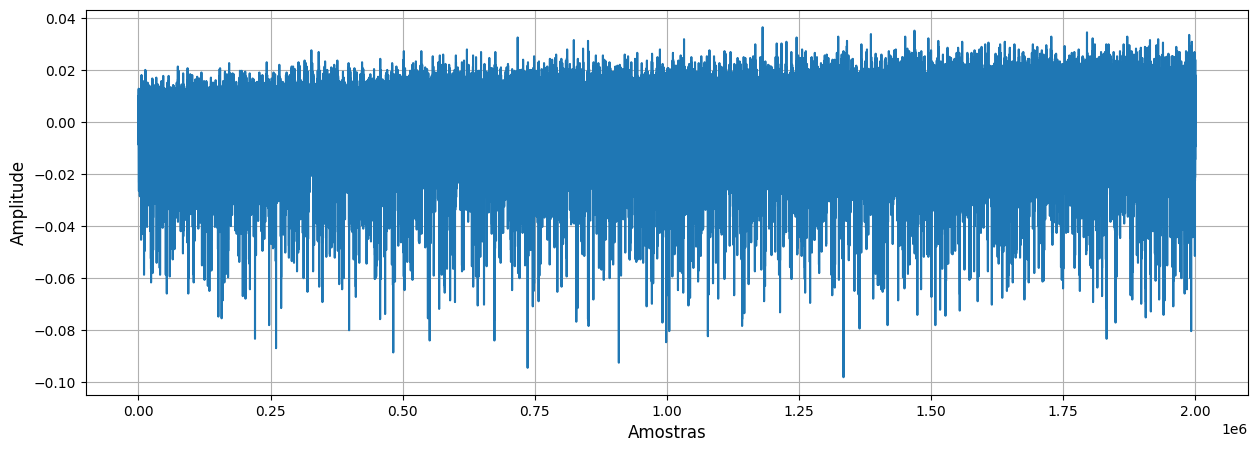

In [10]:
# PLOTAGEM DO SINAL DE VIBRAÇÃO
sinal = HA1
plt.figure(figsize=(15,5))
plt.plot(sinal)
plt.xlabel('Amostras', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid()
plt.show()

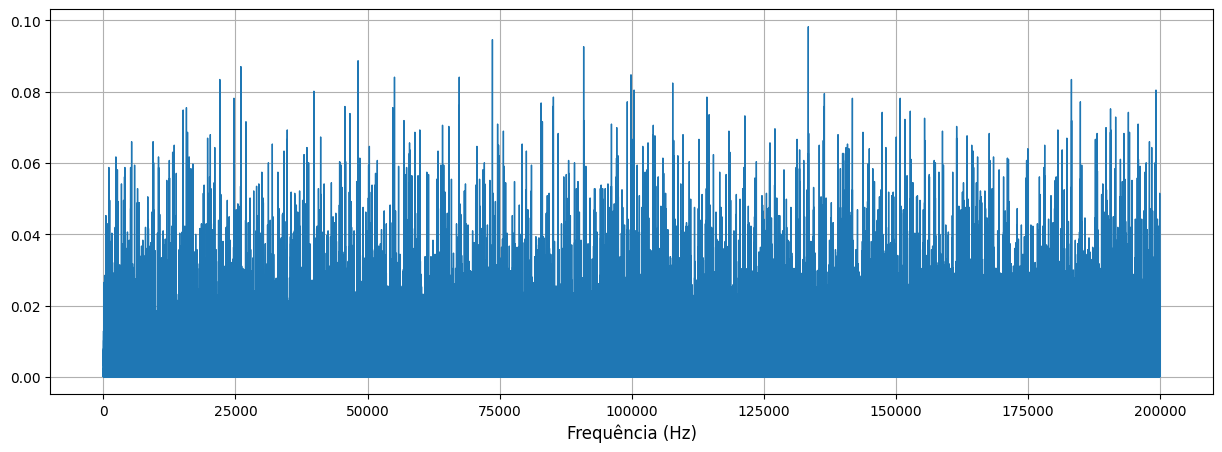

In [11]:
freq_amost = 200e3
freq1 = np.linspace(0, freq_amost, len(sinal))
espec = np.fft.fft(sinal)
plt.figure(figsize=(15,5))
plt.plot(freq1, abs(espec), color='tab:blue', linewidth=1)
plt.xlabel('Frequência (Hz)', fontsize=12)
#plt.title('Espectro da Saída - Sem componente DC', fontsize=14)
plt.grid()
plt.show()